In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import sys
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

sys.path.insert(0,'../src')
from postprocess import *

In [2]:
#experiment,lmt = ['Arabidopsis_GenomeWide_Analysis_euclidean_v8_fixed',0.2]
experiment,lmt = ['Human_Promoter_Analysis_euclidean_v8',0.08]
#experiment,lmt = ['TAL-GATA_binaryFeat_Analysis_allTFs_euclidean_v8_from_customTFs',0.08]

### Processed interactions data

In [3]:
df = pd.read_csv(f'../results/{experiment}/Interactions_SATORI/interactions_summary_attnLimit-{lmt}.txt',sep='\t')

In [4]:
df = filter_data_on_thresholds(df, motifA_pval_cutoff=0.05, motifB_pval_cutoff=0.05)

In [5]:
df.shape

(843, 12)

In [6]:
#df[df['filter_interaction'].isin(filter_pairs_dict.keys())].shape

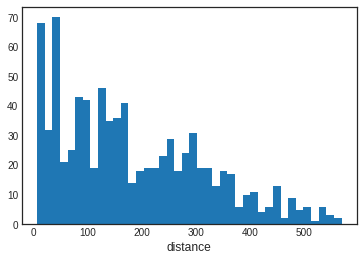

In [8]:
plt.hist(df['mean_distance'], bins=40)
plt.xlabel('distance', size=12)
plt.show()

### Random pairs distance distribution

In [9]:
with open(f'../results/{experiment}/Interactions_SATORI/main_results_raw.pckl','rb') as f:
    attentions, positions, intr_dict = pickle.load(f)
with open(f'../results/{experiment}/Interactions_SATORI/interaction_keys_dict.pckl', 'rb') as f:
    filter_intr_keys = pickle.load(f)

In [10]:
dfm = pd.read_csv(f'../results/{experiment}/Motif_Analysis/tomtom/tomtom.tsv',sep='\t')
dfm = dfm[dfm['q-value']<0.05]
matched_motifs = dfm['Query_ID'].unique().tolist()

In [11]:
intr_dict_all = {}
for item in intr_dict:
    intr_dict_all = {**intr_dict_all, **item[0]}

In [12]:
#len(intr_dict_all)

In [13]:
filter_pairs = random.sample(filter_intr_keys.keys(), df.shape[0])
filter_pairs_dict = {}

In [14]:
for fpair in filter_pairs:
    f1,f2 = fpair.split('<-->')
    if f1 not in matched_motifs or f2 not in matched_motifs: #should be in one of the matched filters
        continue
    diff_list=[]
    for key,val in intr_dict_all.items():
        f1_list = []
        f2_list = []
        for subkey,subval in val.items():
            if f1 in subval and f2 in subval:
                continue
            if f1 in subval:
                f1_list.append(subkey)
            elif f2 in subval:
                f2_list.append(subkey)
        for v1 in f1_list:
            for v2 in f2_list:
                if v1 != v2:
                    diff_list.append(abs(v1-v2)*6)
    filter_pairs_dict[fpair] = np.mean(diff_list)

In [15]:
len(filter_pairs_dict)

228

In [16]:
np.mean(list(filter_pairs_dict.values())), np.median(list(filter_pairs_dict.values()))

(184.96151050912636, 186.2216606498195)

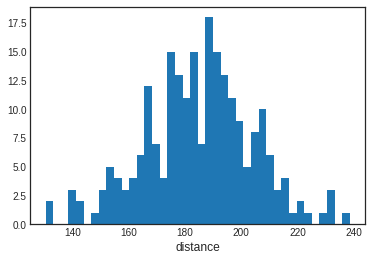

In [17]:
plt.hist(list(filter_pairs_dict.values()), bins=40)
plt.xlabel('distance', size=12)
plt.show()

### Statistical test

In [18]:
#np.std(list(filter_pairs_dict.values())), np.std(df['mean_distance'])
#ttest_ind(list(filter_pairs_dict.values()), df['mean_distance'], equal_var=False)

In [19]:
mannwhitneyu(list(filter_pairs_dict.values()), df['mean_distance'])

MannwhitneyuResult(statistic=81792.0, pvalue=0.0002765622818321296)